In [2]:
import os
import numpy as np
from cycler import cycler

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table, join, hstack
import astropy.units as u

import scipy.stats as stats

plt.rcParams.update({
    'figure.figsize'   : (12, 10),
    'font.family'      :'serif',
    'font.size'        : 24,
    'font.serif'       :'Georgia',
    'axes.labelsize'   :'large',
    'mathtext.fontset' :'stix',
    'axes.linewidth'   : 5,
    'xtick.direction'  :'in',
    'ytick.direction'  :'in',
    'xtick.major.size' : 7,
    'ytick.major.size' : 7,
    'xtick.major.width': 3,
    'ytick.major.width': 3,
    'xtick.minor.size' : 5,
    'ytick.minor.size' : 5,
    'xtick.minor.width': 2,
    'ytick.minor.width': 2,
    'lines.linewidth'  : 3,
    'axes.prop_cycle'  : cycler('color', ['red', 'orange', 'teal', 'skyblue']),
})

def errJy_to_errABmag(flux_Jy, fluxerr_Jy):
    return -2.5 / (flux_Jy * np.log(10)) * fluxerr_Jy

## SOM-ready panchromatic catalog

In [4]:
with fits.open('/data2/lsajkov/mpdg/data/COSMOS/COSMOS2020_CLASSIC_R1_v2.2_p3.fits') as cat:
    COSMOSClassicCat = Table(cat[1].data)

In [5]:
#construct SOM catalog columns
cat = joined_ScienceCat_StellarMassesGKV

def errJy_to_errABmag(flux_Jy, fluxerr_Jy):
    return -2.5 / (flux_Jy * np.log(10)) * fluxerr_Jy

photometric_bands = ['u', 'g', 'r', 'i', 'Z', 'Y', 'J', 'H', 'K']

uberID = cat['uberID']

ra = cat['RAcen']
dec = cat['Deccen']

magnitudes = Table()
SNRs = Table()

for band in photometric_bands:

    magnitudes.add_column((cat[f'flux_{band}t'] * u.Jansky).to(u.ABmag).value,
                          name = f'{band}_mag')
    magnitudes.add_column(errJy_to_errABmag(cat[f'flux_{band}t'], cat[f'flux_err_{band}t']),
                          name = f'{band}_mag_err')
    
    SNRs.add_column(cat[f'flux_{band}t']/cat[f'flux_err_{band}t'],
                    name = band)

colors = Table()
for i, band_hi in enumerate(photometric_bands):
    for band_lo in photometric_bands[i + 1:]:
        color_column = magnitudes[f'{band_hi}_mag'] - magnitudes[f'{band_lo}_mag']
        color_err_column = np.sqrt(magnitudes[f'{band_hi}_mag_err'] ** 2 +\
                                   magnitudes[f'{band_lo}_mag_err'] ** 2)
        colors.add_columns([color_column, color_err_column],
                   names = [f'{band_hi}{band_lo}_col', f'{band_hi}{band_lo}_col_err'])

mstar     = cat['mstar']
mstar_err = cat['delmstar']

R50 = cat['R50']

redshift = cat['Z']
ppp      = cat['ppp']

NQ = cat['NQ']

/data2/lsajkov/mpdg/conda/envs/mpdg/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/var/tmp/lsajkov/ipykernel_2431662/776854917.py:24: RuntimeWarning: divide by zero encountered in divide
  SNRs.add_column(cat[f'flux_{band}t']/cat[f'flux_err_{band}t'],


In [31]:
#construct SOM catalog columns for COSMOS2020 Classic
cat = COSMOSClassicCat

IDs = cat['ID']

photometric_bands = ['CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks']
ra = cat['ALPHA_J2000']
dec = cat['DELTA_J2000']

magnitudes = Table()
magnitude_errs = Table()
SNRs = Table()

for band in photometric_bands:
    magnitudes.add_column((cat[f'{band}_MAG_AUTO']),
                          name = f'{band.split('_')[-1]}_mag')
    magnitude_errs.add_column((cat[f'{band}_MAG_AUTO']),
                          name = f'{band.split('_')[-1]}_magerr')
    SNRs.add_column(cat[f'{band}_FLUX_AUTO']/cat[f'{band}_FLUXERR_AUTO'],
                    name = f'{band.split('_')[-1]}')


colors = Table()
for i, band_hi in enumerate(photometric_bands):
    for band_lo in photometric_bands[i + 1:]:
        color_column = cat[f'{band_hi}_MAG_APER2'] - cat[f'{band_lo}_MAG_APER2']
        color_err_column = np.sqrt(cat[f'{band_hi}_MAGERR_APER2'] ** 2 + cat[f'{band_lo}_MAGERR_APER2'] ** 2)
        colors.add_columns([color_column, color_err_column],
                   names = [f'{band_hi.split('_')[-1]}{band_lo.split('_')[-1]}_col', f'{band_hi.split('_')[-1]}{band_lo.split('_')[-1]}_col_err'])


mstar = 10**cat['lp_mass_med']
mstar_err = 10**cat['lp_mass_med_max68'] - 10**cat['lp_mass_med_min68']

R50 = cat['FLUX_RADIUS']

redshift = cat['lp_zBEST']
redshift_err = cat['lp_zPDF_u68'] - cat['lp_zPDF_l68']

In [32]:
#quality_cuts

SNR_thresh = 5
SNR_mask = (SNRs['r'] > SNR_thresh) &\
           (SNRs['i'] > SNR_thresh) &\
           (SNRs['z'] > SNR_thresh) &\
           (SNRs['Y'] > SNR_thresh) &\
           (SNRs['J'] > SNR_thresh) &\
           (SNRs['H'] > SNR_thresh) &\
           (SNRs['Ks'] > SNR_thresh)

redshift_mask = (redshift >= 0.002) & (redshift < 1)

color_lo = -1
color_hi = 3
color_mask = np.ones(len(cat), dtype = bool)
for color in colors.colnames:
    if ~color.endswith('_err'):
        color_mask = color_mask &\
                    (colors[color] > color_lo) & (colors[color] < color_hi) &\
                    ~np.isnan(colors[color])
        
log_mstar_lo = 6
log_mstar_hi = 12
log_mstar_mask = (np.log10(mstar) > log_mstar_lo) & (np.log10(mstar) < log_mstar_hi)

R50_mask = R50 < 10

r_mag_mask = magnitudes['r_mag'] > 18

/var/tmp/lsajkov/ipykernel_2431662/2752200513.py:18: DeprecationWarning: Bitwise inversion '~' on bool is deprecated. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  if ~color.endswith('_err'):


In [34]:
total_mask = SNR_mask &\
             redshift_mask &\
             color_mask &\
             log_mstar_mask &\
             R50_mask &\
             r_mag_mask

In [35]:
COSMOS_training_catalog = Table([IDs,
                                 ra, dec,
                                 mstar, redshift,
                                 redshift,
                                 R50],
                          names = ['ID',
                                   'ra', 'dec',
                                   'mstar', 'mstar_err',
                                   'redshift',
                                   'half_light_radius'])

COSMOS_training_catalog.add_columns(colors.columns,
                                      indexes = [3] * len(colors.colnames))

COSMOS_training_catalog.add_columns(magnitudes.columns,
                                      indexes = [3] * len(magnitudes.colnames))

COSMOS_training_catalog = COSMOS_training_catalog[total_mask]

(array([   54.,   343.,  1410.,  4199., 11031., 21691., 30031., 23971.,
         8318.,   564.]),
 array([18.30161858, 19.31667709, 20.3317337 , 21.34679031, 22.36184883,
        23.37690735, 24.39196396, 25.40702057, 26.42207909, 27.4371376 ,
        28.45219421]),
 <BarContainer object of 10 artists>)

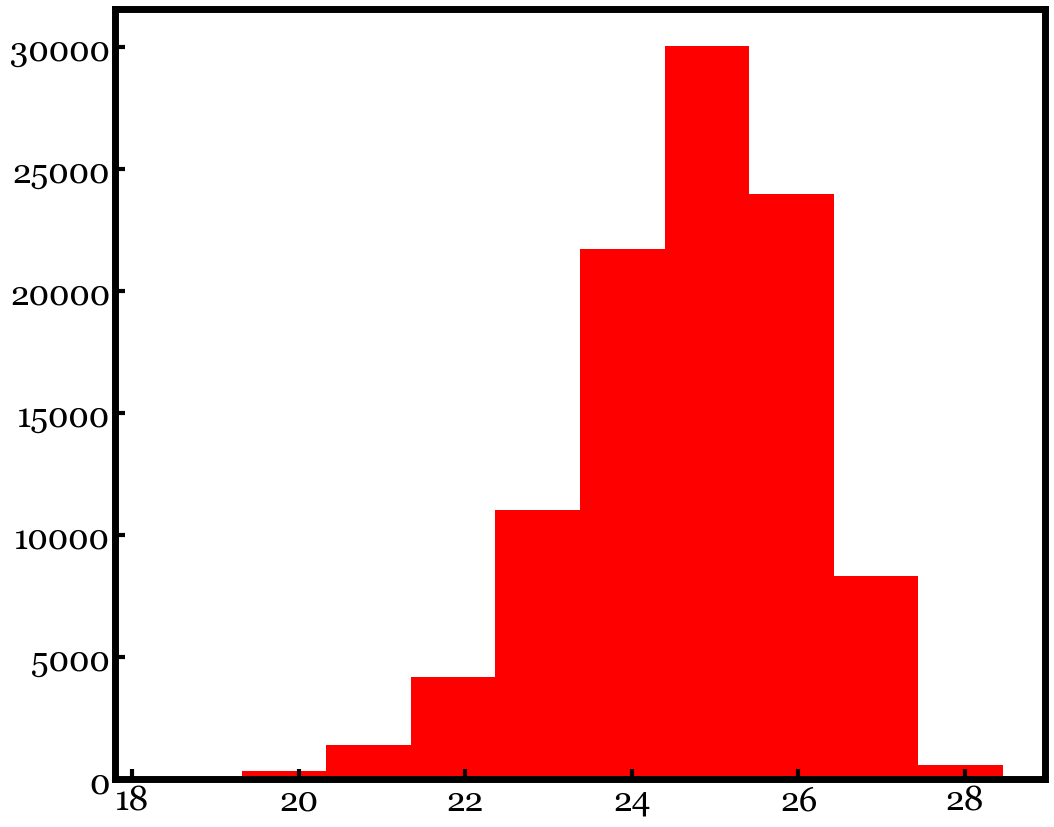

In [39]:
plt.hist(COSMOS_training_catalog['r_mag'])

In [38]:
COSMOS_training_catalog.write('/data2/lsajkov/mpdg/data_products/COSMOS/COSMOS_SOM_panchromatic_catalog_05Aug24.fits',
                                overwrite = False)

## SOM-ready restframe catalog

In [2]:
with fits.open('/data2/lsajkov/mpdg/data/GAMA/gkvScienceCatv02.fits') as cat:
    ScienceCat = Table(cat[1].data)

with fits.open('/data2/lsajkov/mpdg/data/GAMA/StellarMassesGKVv24.fits') as cat:
    StellarMassesGKV = Table(cat[1].data)
    
joined_ScienceCat_StellarMassesGKV = join(ScienceCat, StellarMassesGKV)

In [ ]:
#construct SOM catalog columns
cat = joined_ScienceCat_StellarMassesGKV

def errJy_to_errABmag(flux_Jy, fluxerr_Jy):
    return -2.5 / (flux_Jy * np.log(10)) * fluxerr_Jy

uberID = cat['uberID']

r_mag = (cat['flux_rt'] * u.Jansky).to(u.ABmag).value
r_mag_err = errJy_to_errABmag(cat['flux_rt'], cat['flux_err_rt'])
r_snr = cat['flux_rt']/cat['flux_err_rt']

g_mag = (cat['flux_gt'] * u.Jansky).to(u.ABmag).value
g_mag_err = errJy_to_errABmag(cat['flux_gt'], cat['flux_err_gt'])
g_snr = cat['flux_gt']/cat['flux_err_gt']

u_mag = (cat['flux_ut'] * u.Jansky).to(u.ABmag).value
u_mag_err = errJy_to_errABmag(cat['flux_ut'], cat['flux_err_ut'])
u_snr = cat['flux_ut']/cat['flux_err_ut']

i_mag = (cat['flux_it'] * u.Jansky).to(u.ABmag).value
i_mag_err = errJy_to_errABmag(cat['flux_it'], cat['flux_err_it'])
i_snr = cat['flux_it']/cat['flux_err_it']

Z_mag = (cat['flux_Zt'] * u.Jansky).to(u.ABmag).value
Z_mag_err = errJy_to_errABmag(cat['flux_Zt'], cat['flux_err_Zt'])
Z_snr = cat['flux_Zt']/cat['flux_err_Zt']

ur_rest     = cat['uminusr']
ur_rest_err = cat['deluminusr']

gi_rest     = cat['gminusi']
gi_rest_err = cat['delgminusi']



mstar     = cat['mstar']
mstar_err = cat['delmstar']

R50 = cat['R50']

redshift = cat['Z']
ppp      = cat['ppp']